## Objective

    OK - Open each image, split it in 4x4. 
    OK - Use find_voids to count number of voids in it.
    WIP- Colorize grains (1)
    4 - If voids>0 
            Recontruct boundaries
            Colorize after reconstruction (2)
        Else
            Copy (1)

    5 - Save (1) and (2) as train dataset



### Open images and split in 16


In [1]:
import pandas as pd
import numpy as np
from skimage import draw,io
from skimage.segmentation import flood, flood_fill
import cv2
import math
from matplotlib import pyplot as plt

import find_voids as fv


In [2]:

folder = "../data/"
file = "1_001"
path = folder + file

#%%

sample = np.loadtxt(path+ ".txt")

'''
# Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
# Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
# Column 7:     Misorientation Angle
# Column 8-10:  Misorientation Axis in Right Hand grain
# Column 11-13: Misorientation Axis in Left Hand grain
# Column 14:    length (in microns)
# Column 15:    trace angle (in degrees)
# Column 16-19: x,y coordinates of endpoints (in microns)
# Column 20-21: IDs of right hand and left hand grains

'''


df = pd.DataFrame(  data = sample, 
                    columns = ["right_phi1","right_PHI","right_phi2",                 #1-3
                               "left_phi1","left_PHI","left_phi2",                    #4-6 
                               "ori_angle",                                           #7
                               "right_ori_x","right_ori_y","right_ori_z",              #8-10
                               "left_ori_x","left_ori_y","left_ori_z",                 #11-13  
                               "length",                                              #14
                               "trace_angle",                                         #15
                               "x_start", "y_start", "x_end", "y_end",                #16-19
                               "grain_right","grain_left"                             #20-21
                               ]                    
                 )


In [3]:

df_left = df[['left_phi1','left_PHI','left_phi2','grain_left']]
df_left = df_left.rename(columns={"grain_left": "grain"})

df_left = df_left[~df_left.grain.duplicated()].sort_values('grain')
df_left = df_left.set_index('grain')



df_right = df[['right_phi1','right_PHI','right_phi2','grain_right']]
df_right = df_right.rename(columns={"grain_right": "grain"})

df_right = df_right[~df_right.grain.duplicated()].sort_values('grain')
df_right = df_right.set_index('grain')



df_grains = df_left.join(df_right)

df_grains_norm = (df_grains - df_grains.min()) / (df_grains.max() - df_grains.min())

In [4]:

width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1

flood_grains = np.zeros([height, width, 3])
overflood = np.sum(flood_grains==0) * 0.8

for grain in df_grains.index:
    One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
    grain_info = df_grains_norm.loc[grain,:]
    np_img = np.zeros([height, width, 3])

  #  width = int(max([max(One_grain.x_end),max(One_grain.x_start)]))+1
  #  height = int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1

    x_center = math.floor(One_grain[['x_start','x_end']].mean().mean())
    y_center = math.floor(One_grain[['y_start','y_end']].mean().mean())


    if(y_center < 2100 and y_center < 2400):    
        phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
        #    cv2.putText(np_img, text=str(int(grain)), org=(x_center,y_center),fontFace=2, fontScale=0.4, color=(255,255,255), thickness=1)
    
        for idx, row in One_grain.iterrows():
            
            rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
            np_img[cc,rr] = (1,1,1)
        
        mask = flood(np_img, (y_center, x_center,0))
#        print(str(grain) + " len "+ str(np.count_nonzero(mask)))
#         print(str(grain) + " len 0 "+ str(np.sum(mask==1)))
        np_img[np_img[:,:,1] !=0] =  [0,0,0]#[phi1,Phi,phi2]
        
#         cv2.imshow('NP',np_img)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

        if (np.sum(mask==1)<overflood):
            np_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
            
        else:
            start = pd.DataFrame(columns=["x","y"])
            end = pd.DataFrame(columns=["x","y"])
            start[["x","y"]] = One_grain[['x_start','y_start']]
            end[["x","y"]] = One_grain[['x_end','y_end']]
            points = pd.concat([start,end])
            

            
            try :
                hull = ConvexHull(points)
                for idx in range(len(hull.simplices)):
                    x_s = hull.points[hull.simplices[idx,0], 0].astype("uint16")
                    y_s = hull.points[hull.simplices[idx,0], 1].astype("uint16")
                    x_e = hull.points[hull.simplices[idx,1], 0].astype("uint16")
                    y_e = hull.points[hull.simplices[idx,1], 1].astype("uint16")

                    rr,cc,a = draw.line_aa(x_s,y_s,x_e,y_e)
                    
                    np_img[cc,rr] = (1,1,1)
                mask = flood(np_img, (y_center, x_center,0))

                np_img[np_img[:,:,1] !=0] =  [0,0,0]
                np_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
            except:
                #print(points)
                pass
           
            
            
            
        flood_grains += np_img
#         cv2.imshow('Image',flood_grains)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

        
N = width//4
M = height//4

tiles = [flood_grains[x:x+M,y:y+N] for x in range(0,flood_grains.shape[0],M) for y in range(0,flood_grains.shape[1],N)]


In [12]:
cv2.imshow('Image',flood_grains)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [6]:
np_img = np.zeros([height, width, 3])
np.sum(np_img==0)

3144000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

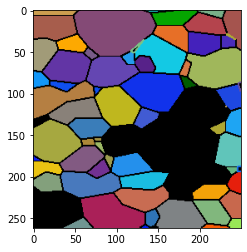

In [7]:
for tile in tiles:
#    centers, radii, vheight, image, drawing = fv.find_voids_2(tile)
    plt.imshow(tile)

In [8]:

width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1

N = width//4
M = height//4

full_img = np.zeros([height, width, 3])

for idx, row in df.iterrows():
    #print("%d %d %d %d\n" %(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16")))    
    rr,cc= draw.line(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
    full_img[cc,rr,:3] = (1,1,1)

tiles = [full_img[x:x+M,y:y+N] for x in range(0,full_img.shape[0],M) for y in range(0,full_img.shape[1],N)]



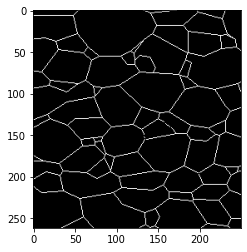

In [9]:
plt.imshow(tiles[15])

In [10]:
len(tiles)

16

### Creating tiles from original image and detecting voids

The program has detected 0 voids
The program has detected 0 voids
The program has detected 0 voids
The program has detected 0 voids
The program has detected 0 voids
The program has detected 0 voids
The program has detected 4 voids
The program has detected 1 voids
The program has detected 1 voids
The program has detected 1 voids
The program has detected 1 voids
The program has detected 1 voids
The program has detected 0 voids
The program has detected 0 voids
The program has detected 1 voids
The program has detected 0 voids


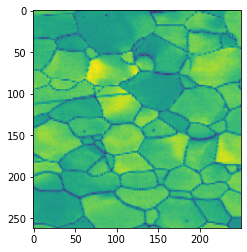

In [11]:

grey_img = cv2.imread(path+ '.jpg', 0)
grey_img = cv2.resize(grey_img,(width,height),interpolation = cv2.INTER_AREA)

tiles_grey = [grey_img[x:x+M,y:y+N] for x in range(0,grey_img.shape[0],M) for y in range(0,grey_img.shape[1],N)]

for tile in tiles_grey:
    centers, radii, vheight, image, drawing = fv.find_voids_2(tile)
    plt.imshow(tile)